In [2]:
import h5py
from glob import glob
import numpy as np
from datetime import datetime

import pandas as pd
import xarray as xr

from dask import array as da
from dask import delayed

from iwaves.utils import isw

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

In [3]:
#%matplotlib notebook
%matplotlib inline

In [4]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize':'large'})

In [12]:
# Load the converted data
#ds = xr.open_dataset('../../kdv_solutions_azure/kdv_all_ensembles.nc')
#ds = xr.open_dataset('../output/kdv_all_ensembles_magnus.nc')
#ds = xr.open_dataset('../output/kdv_magnus_x100km_v3.nc')
#ds = xr.open_dataset('../output/2019-07-03--06-58-08_magnus_kdv_runs.nc')
timetoday = 0.25
alphavar = 'alpha'
cvar = 'cn'

#ds = xr.open_dataset('../output/2019-07-10--00-44-01_magnus_kdv_runs.nc')
#timetoday = 1

#ds_raw = xr.open_dataset('../output/2019-07-11--01-47-43_magnus_kdv_runs.nc')
#ds_raw = xr.open_dataset('../output/2019-07-15--11-53-58_magnus_kdv_runs.nc') #KdV w/ new a0
##ds = xr.open_dataset('../output/2019-07-16--05-17-35_magnus_kdv_runs.nc') #eKdV w/ new a0
#betafile = '../inputs/ShellCrux_Filtered_Density_BHM_VI_20162017.h5'

#ds= xr.open_dataset('../output/magnus_kdv_runs_mcmc_beta_new_a0.nc')
#betafile = '../inputs/ShellCrux_Filtered_Density_BHM_MCMC_20162017.h5'

#ds= xr.open_dataset('../output/magnus_kdv_runs_mcmc_beta_new_a0_dt10.nc')
#betafile = '../inputs/ShellCrux_Filtered_Density_BHM_MCMC_20162017.h5'

# Old bathymetry
#ds= xr.open_dataset('../output/magnus_kdv_runs_vi_beta_new_a0.nc')

# New bathymetry
# ds = xr.open_dataset('../output/magnus_kdv_runs_vi_beta_lag_a0_welbathy.nc')

# New a0 - optimal
# ds = xr.open_dataset('../output/2019-10-04--02-58-30_slim-a0_optimal_GP_magnus_kdv_runs.nc')


# ds= xr.open_dataset('../output/magnus_kdv_runs_vi_beta_lag_a0.nc')
# betafile = '../inputs/ShellCrux_Uniltered_Density_BHM_VI_20162017.h5'
# sitename = 'KP150_12mth_filtered_vi_welbathy'


ds= xr.open_dataset('../output/2019-11-12--00-42-28_slim-harmonic_beta_pred_a0_magnus_kdv_runs.nc')
ds = ds.sel(time=range(0,367))

betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_harmonicfit_M2S2nonstat_N2K1O1_12month.h5'
sitename = 'harmonic_beta_a0_20162017'


#ds_raw = xr.open_dataset('../output/2019-07-12--02-41-51_magnus_kdv_runs.nc') # mcmc stratification

timetoday = 1
alphavar = 'alpha_mu'
cvar = 'cn_mu'

outpath = '../FIGURES'
#ds = ds_raw.where(ds_raw['a0'] != -999.)  
ds

<xarray.Dataset>
Dimensions:    (ensemble: 500, params: 6, time: 367)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365 366
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params     (params) int64 0 1 2 3 4 5
Data variables:
    amax       (ensemble, time) float64 ...
    tmax       (ensemble, time) float64 ...
    a0         (ensemble, time) float64 ...
    cn         (ensemble, time) float64 ...
    alpha      (ensemble, time) float64 ...
    alpha2     (ensemble, time) float64 ...
    cn_mu      (ensemble, time) float64 ...
    alpha_mu   (ensemble, time) float64 ...
    alpha2_mu  (ensemble, time) float64 ...
    beta       (time, ensemble, params) float64 ...
    ubed       (ensemble, time) float64 ...
    usurf      (ensemble, time) float64 ...

In [13]:
# Time in days
timedays = ds.time * timetoday
nt = timedays.shape[0]

# Get the time from the beta file
with h5py.File(betafile,'r') as f:
    t=f['data/time'][:].astype('<M8[ns]')
time = t[:nt]
#nt = time.shape[0]

#ds = ds.sel(time=range(nt))
#ds,nt

In [14]:
ds.amax.max(), ds.amax.min()

(<xarray.DataArray 'amax' ()>
 array(33.28316), <xarray.DataArray 'amax' ()>
 array(-999.))

In [15]:
amax_min = ds.amax.min(axis=0)
amax_max = ds.amax.max(axis=0)
amax_50 = np.mean(ds.amax, axis=0)


a0_min = ds.a0.min(axis=0)
a0_max = ds.a0.max(axis=0)
a0_50 = np.mean(ds.a0, axis=0)

# time
tmax = ds.tmax.values/(12.42*3600)
#tmax[tmax>3]=tmax[tmax>3]-1
tmax_min = tmax.min(axis=0)
tmax_max = tmax.max(axis=0)
tmax_50 = np.mean(tmax, axis=0)


alpha_mu_min = ds[alphavar].min(axis=0)
alpha_mu_max = ds[alphavar].max(axis=0)
alpha_mu_50 = np.median(ds[alphavar], axis=0)

alpha_min = ds['alpha'].min(axis=0)
alpha_max = ds['alpha'].max(axis=0)
alpha_50 = np.median(ds['alpha'], axis=0)



In [16]:
T = 12.42*3600.
omega = 2*np.pi / T
Ls = ds.cn**2. / (np.abs(ds.alpha)*ds.a0*omega) 
Ls_mu = ds[cvar]**2. / (ds[alphavar]*ds.a0*omega) 

L = 1.05e5

Ls_mu_min = np.abs(Ls_mu).min(axis=0)
Ls_mu_max = np.abs(Ls_mu).max(axis=0)
Ls_mu_50 = np.mean(np.abs(Ls_mu), axis=0)


Ls_min = np.abs(Ls).min(axis=0)
Ls_max = np.abs(Ls).max(axis=0)
Ls_50 = np.mean(np.abs(Ls), axis=0)

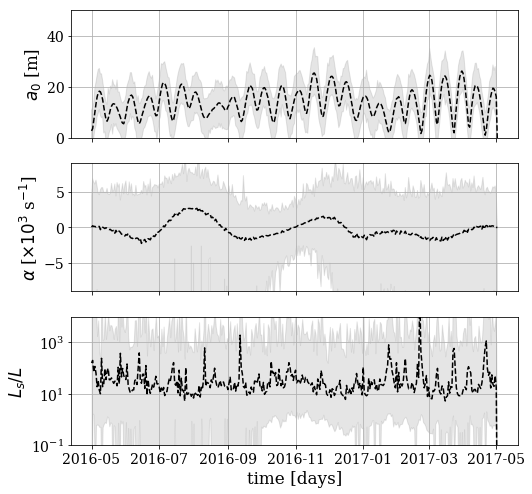

In [17]:
fig=plt.figure(figsize=(8,8))
ax1=plt.subplot(311)
plt.fill_between(time, a0_min, a0_max, color='0.5',alpha=0.2)
plt.plot(time,a0_50,'k--', lw=1.5)
plt.ylabel('$a_0$ [m]')
plt.ylim(0,50)
#plt.xlabel('time [days]')
ax1.set_xticklabels([])

plt.grid(b=True)

ax2=plt.subplot(312)
plt.fill_between(time, alpha_min*1000, alpha_max*1000, color='0.5',alpha=0.2)
plt.plot(time,alpha_50*1000,'k--', lw=1.5)
plt.ylabel(r'$\alpha$ [$\times 10^3$ s$^{-1}$]')
plt.ylim(-9,9)
ax2.set_xticklabels([])
#plt.xlabel('time [days]')
plt.grid(b=True)

ax3=plt.subplot(313)
plt.fill_between(time, Ls_min/L, Ls_max/L, color='0.5',alpha=0.2)
plt.plot(time,Ls_50/L,'k--', lw=1.5)

plt.ylabel('$L_s/L$')
plt.xlabel('time [days]')
ax3.set_yscale('log')
plt.grid(b=True)
plt.ylim(0.1,1e4)


#plt.savefig('../FIGURES/kdv_12month_a0_Ls.png',dpi=150)
#plt.savefig('../FIGURES/kdv_12month_a0_Ls.pdf',dpi=150)

plt.show()

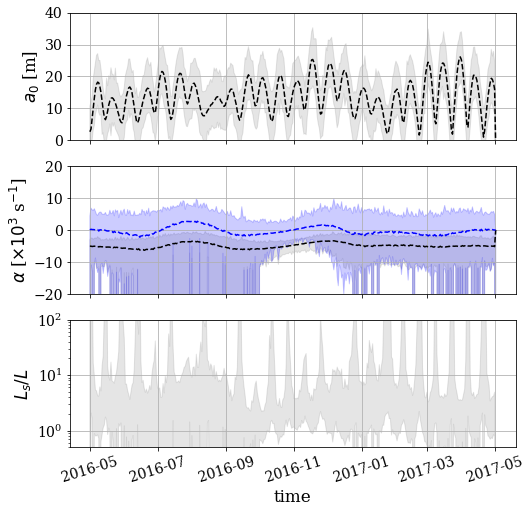

In [20]:
fig=plt.figure(figsize=(8,8))
ax1=plt.subplot(311)
plt.fill_between(time, a0_min, a0_max, color='0.5',alpha=0.2)
plt.plot(time,a0_50,'k--', lw=1.5)
plt.ylabel('$a_0$ [m]')
plt.ylim(0,40)
#plt.xlabel('time [days]')
ax1.set_xticklabels([])

plt.grid(b=True)

ax2=plt.subplot(312)
plt.fill_between(time, alpha_mu_min*1000, alpha_mu_max*1000, color='0.5',alpha=0.2)
plt.plot(time,alpha_mu_50*1000,'k--', lw=1.5)

plt.fill_between(time, alpha_min*1000, alpha_max*1000, color='b',alpha=0.2)
plt.plot(time,alpha_50*1000,'b--', lw=1.5)
plt.ylabel(r'$\alpha$ [$\times 10^3$ s$^{-1}$]')
plt.ylim(-20,20)
ax2.set_xticklabels([])
#plt.xlabel('time [days]')
plt.grid(b=True)

ax3=plt.subplot(313)
plt.fill_between(time, Ls_mu_min/L, Ls_mu_max/L, color='0.5',alpha=0.2)
#plt.plot(time,Ls_mu_50/L,'k--', lw=1.5)

plt.ylabel('$L_s/L$')
plt.xlabel('time')
ax3.set_yscale('log')
plt.grid(b=True)
plt.ylim(0.5,1e2)
plt.xticks(rotation=17)

#plt.savefig('../FIGURES/kdv_12month_a0_A.png',dpi=150)
plt.savefig('../FIGURES/kdv_12month_a0_Ls_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_a0_Ls_{}.pdf'.format(sitename),dpi=150)

plt.show()

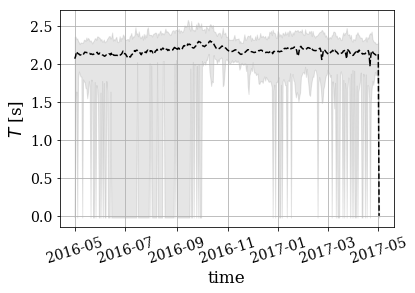

In [21]:
#plot the time
plt.figure()
plt.fill_between(time, tmax_min, tmax_max, color='0.5',alpha=0.2)
plt.plot(time,tmax_50,'k--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$T$ [s]')
plt.xticks(rotation=17)

plt.xlabel('time')
plt.grid(b=True)

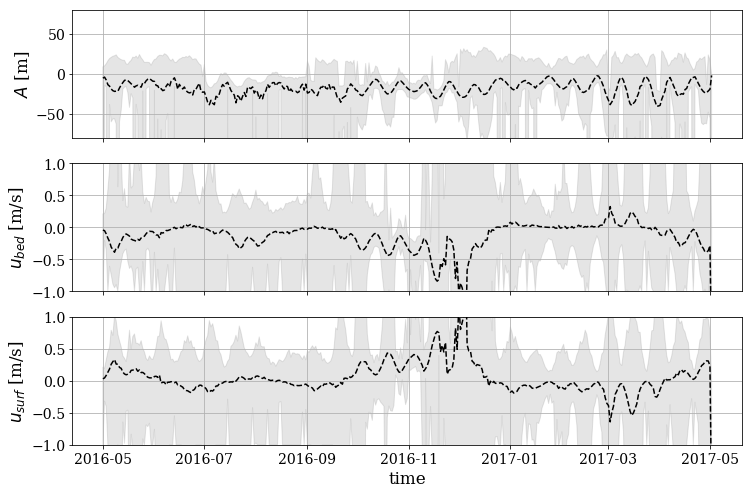

In [22]:

ubed_min = ds.ubed.min(axis=0)
ubed_max = ds.ubed.max(axis=0)
ubed_50 = np.mean(ds.ubed, axis=0)


usurf_min = ds.usurf.min(axis=0)
usurf_max = ds.usurf.max(axis=0)
usurf_50 = np.mean(ds.usurf, axis=0)

plt.figure(figsize=(12,8))

ax1=plt.subplot(311)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.plot(time,amax_50,'k--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$A$ [m]')
plt.grid(b=True)
plt.ylim([-80,80])
ax1.set_xticklabels([])

ax2=plt.subplot(312)
plt.fill_between(time, ubed_min, ubed_max, color='0.5',alpha=0.2)
plt.plot(time,ubed_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$u_{bed}$ [m/s]')
plt.ylim(-1.0,1.0)
#plt.xlabel('time [days]')
plt.grid(b=True)
ax2.set_xticklabels([])


ax3= plt.subplot(313)
plt.fill_between(time, usurf_min, usurf_max, color='0.5',alpha=0.2)
plt.plot(time,usurf_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$u_{surf}$ [m/s]')
plt.ylim(-1.0,1.0)

plt.xlabel('time')
plt.grid(b=True)



#plt.savefig('../FIGURES/kdv_12month_velocity.png',dpi=150)
plt.show()

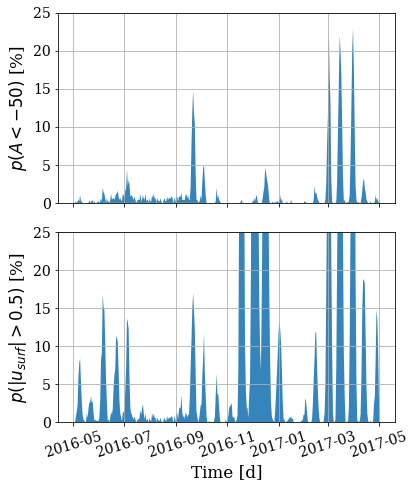

In [23]:
# Inference example
# Calculate the probability of A < -50 and u_bed < -0.5 m/s
ubed_thresh = np.abs(ds.usurf) > 0.6
ns = ubed_thresh.shape[0]
A_thresh = ds.amax < -50.

p_ubed = np.sum(ubed_thresh,axis=0)/ns * 100.
p_A = np.sum(A_thresh,axis=0)/ns * 100.

plt.figure(figsize=(6,7))

ax1 = plt.subplot(211)
plt.fill_between(time, p_A,alpha = 0.9)

plt.ylim(0,25)
plt.grid(b=True)
ax1.set_xticklabels([])

plt.ylabel('$p(A<-50)$ [%]')

ax2 = plt.subplot(212)
plt.fill_between(time, p_ubed,alpha = 0.9)
#ax1.set_xticklabels([])
plt.ylabel('$p(|u_{surf}|>0.5)$ [%]')
plt.ylim(0,25)
plt.grid(b=True)
plt.xlabel('Time [d]')
plt.xticks(rotation=17)

plt.tight_layout()


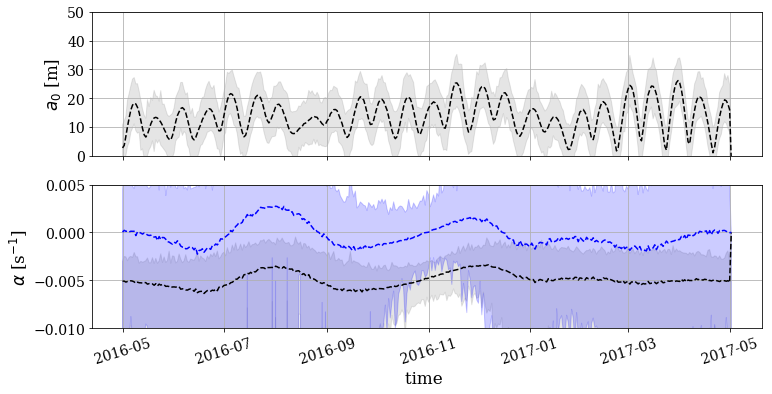

In [24]:
plt.figure(figsize=(12,9))
ax1=plt.subplot(311)
plt.fill_between(time, a0_min, a0_max, color='0.5',alpha=0.2)
plt.plot(time,a0_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$a_0$ [m]')
plt.ylim(0,50)
ax1.set_xticklabels([])

#plt.xlabel('time [days]')
plt.grid(b=True)

ax2=plt.subplot(312)
plt.fill_between(time, alpha_mu_min, alpha_mu_max, color='0.5',alpha=0.2)
plt.plot(time,alpha_mu_50,'k--', lw=1.5)

plt.fill_between(time, alpha_min, alpha_max, color='b',alpha=0.2)
plt.plot(time,alpha_50,'b--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
plt.ylim(-0.01,0.005)
#ax2.set_xticklabels([])
plt.xlabel('time ')
plt.grid(b=True)

plt.xticks(rotation=17)


#plt.savefig('../FIGURES/kdv_12month_a0_A_alpha.png',dpi=150)

plt.show()

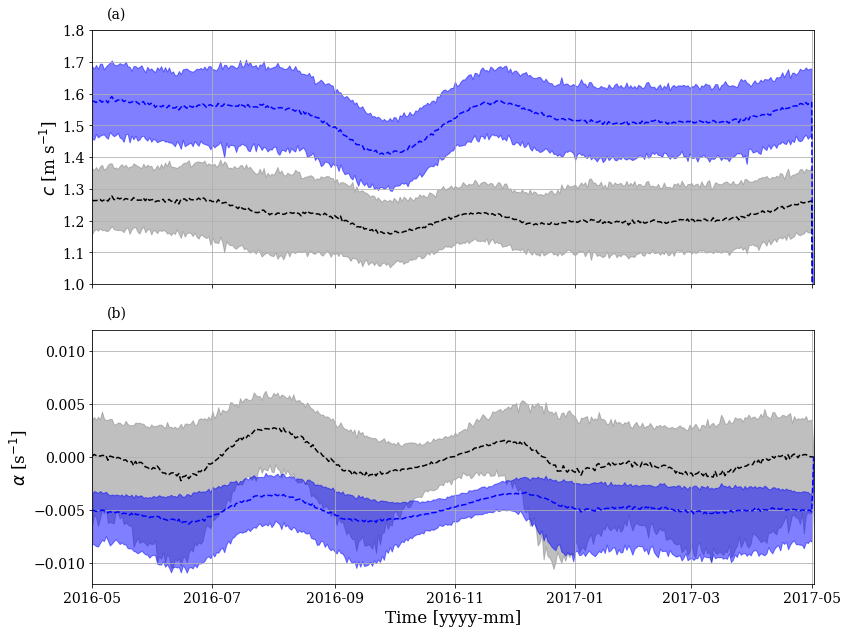

In [26]:
alpha_min = np.percentile(ds.alpha,2.5,axis=0)
alpha_max = np.percentile(ds.alpha,97.5,axis=0)
alpha_50 = np.median(ds.alpha, axis=0)

alpha_mu_min = np.percentile(ds.alpha_mu,2.5,axis=0)
alpha_mu_max = np.percentile(ds.alpha_mu,97.5,axis=0)
alpha_mu_50 = np.median(ds.alpha_mu, axis=0)

c_min = np.percentile(ds.cn,2.5,axis=0)
c_max = np.percentile(ds.cn,97.5,axis=0)
c_50 = np.median(ds.cn, axis=0)

cmu_min = np.percentile(ds.cn_mu,2.5,axis=0)
cmu_max = np.percentile(ds.cn_mu,97.5,axis=0)
cmu_50 = np.median(ds.cn_mu, axis=0)


# time = ds.time.values

nt = time.shape[0]
plt.figure(figsize=(12,9))
ax1=plt.subplot(211)
plt.fill_between(time, c_min, c_max, color='0.5',alpha=0.5)
plt.plot(time,c_50,'k--', lw=1.5)

plt.fill_between(time, cmu_min, cmu_max, color='b',alpha=0.5)
plt.plot(time,cmu_50,'b--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$c$ [m s$^{-1}$]')
plt.ylim(1.0,1.80)
ax1.set_xticklabels([])
plt.xlim(time[0],time[-1])

#plt.xlabel('time [days]')
plt.grid(b=True)
plt.text(0.02,1.05,'(a)',transform=ax1.transAxes)


ax2=plt.subplot(212)
plt.fill_between(time, alpha_min, alpha_max, color='0.5',alpha=0.5)
plt.plot(time,alpha_50,'k--', lw=1.5)

plt.fill_between(time, alpha_mu_min, alpha_mu_max, color='b',alpha=0.5)
plt.plot(time,alpha_mu_50,'b--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
plt.ylim(-0.012,0.012)
#ax2.set_xticklabels([])
#plt.xlabel('time [days]')
plt.grid(b=True)
plt.xlim(time[0],time[-1])
plt.text(0.02,1.05,'(b)',transform=ax2.transAxes)
plt.xlabel('Time [yyyy-mm]')

plt.tight_layout()


plt.savefig('%s/alpha_cn_timeseries_%s.png'%(outpath, sitename), dpi=150)
plt.savefig('%s/alpha_cn_timeseries_%s.pdf'%(outpath, sitename), dpi=150)

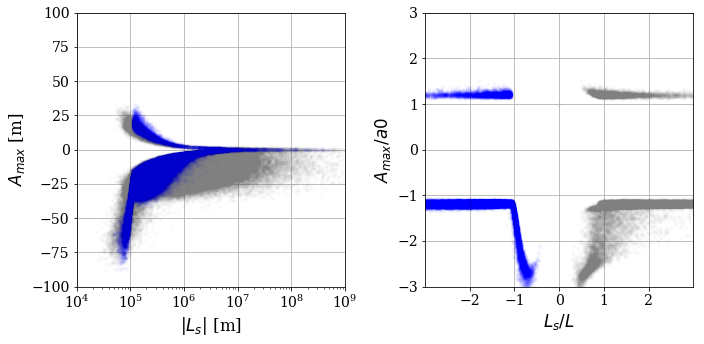

In [27]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.semilogx(np.abs(Ls), ds.amax, '.', color='0.5', alpha=0.02)
plt.semilogx(np.abs(Ls_mu), ds.amax, '.', color='b', alpha=0.02)

plt.xlim(1e4,1e9)
#plt.ylim(-4,4)
plt.grid(b=True)

plt.ylabel(r'$A_{max}$ [m]')
plt.xlabel('$|L_s|$ [m]')
plt.ylim(-100,100)

plt.subplot(122)
plt.plot(Ls/L, ds.amax/ds.a0, '.', color='0.5', alpha=0.02)
plt.plot(Ls_mu/L, ds.amax/ds.a0, '.', color='b', alpha=0.02)

plt.xlim(-3.0,3.0)
plt.ylim(-3,3)
#plt.xticks([-2.0,-1.5,-1.0,-0.5,0,0.5,1.,1.5,2.])
plt.grid(b=True)

plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')
plt.xticks([-2,-1,0,1,2])
#plt.legend(('$L_s$','$\overline{L_s}$',))

plt.tight_layout()

#plt.savefig('../FIGURES/kdv_Amax_vs_Ls.png',dpi=150)


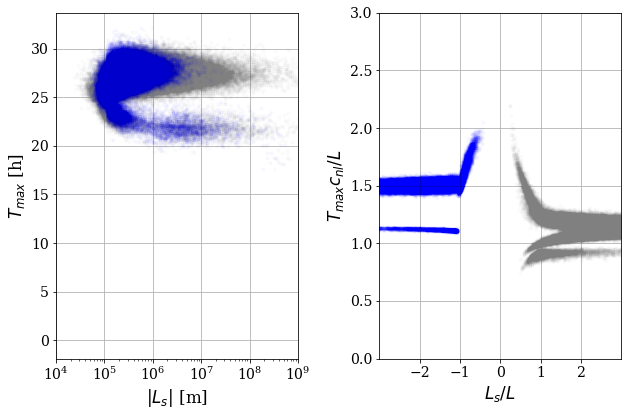

In [28]:
plt.figure(figsize=(9,6))

plt.subplot(121)
plt.semilogx(np.abs(Ls), tmax*T/3600., '.', color='0.5', alpha=0.02)
plt.semilogx(np.abs(Ls_mu), tmax*T/3600., '.', color='b', alpha=0.02)


#plt.semilogx(Ls, ds.tmax*ds.cn/L, '.', color='navy', alpha=0.02)

plt.xlim(1e4,1e9)
#plt.ylim(1,4)
plt.grid(b=True)

plt.ylabel(r'$T_{max}$ [h]')
plt.xlabel('$|L_s|$ [m]')

plt.subplot(122)
c_nl = ds.cn + ds.amax*ds.alpha
c_nl_mu = ds[cvar] + ds.amax*ds[alphavar]

plt.plot(Ls/L, tmax*T*c_nl/L, '.', color='0.5', alpha=0.02)
plt.plot(Ls_mu/L, tmax*T*c_nl_mu/L, '.', color='b', alpha=0.02)

#plt.plot(ds.amax*ds.alpha/ds.cn, tmax*T*ds.cn/L, '.', color='navy', alpha=0.02)


#plt.semilogx(Ls/L, ds.amax/ds.a0, '.', color='navy', alpha=0.02)
plt.xlim(-3,3)
plt.ylim(0,3)
plt.grid(b=True)

plt.ylabel(r'$T_{max}c_{nl}/L$')
plt.xlabel('$L_s / L$')
plt.xticks([-2,-1,0,1,2])


plt.tight_layout()

#plt.savefig('../FIGURES/kdv_Amax_vs_Ls.png',dpi=150)

In [29]:
# Plot with the parametric forms overlaid

def calc_Ahat_quadratic(Lhat, coeffs):
    a0, a1, x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = a1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1


    return Ahat

Lhat = np.linspace(-3,-0.5,500)
#Ahat_g = calc_Ahat_quadratic(Lhat,(-2.68,1.25,-0.65))
Ahat_g = calc_Ahat_quadratic(Lhat,(-2.60,1.15,-0.65))

That_g = calc_That_quadratic(Lhat,(1.95,1.5,-0.1))

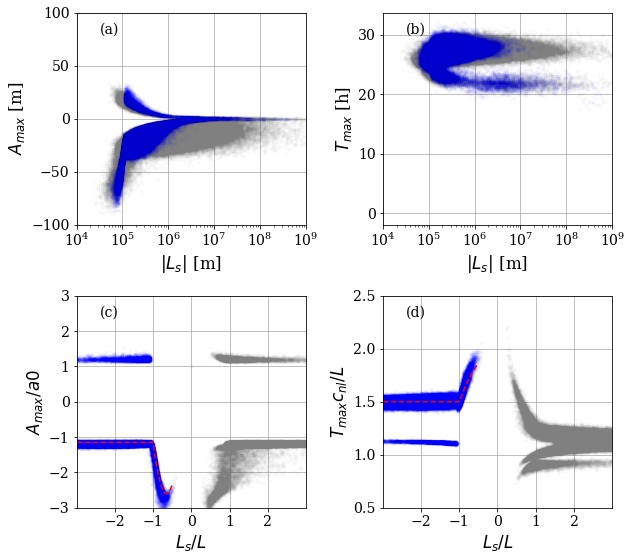

In [30]:
plt.figure(figsize=(9,8))

ax1=plt.subplot(221, rasterized=True)
plt.semilogx(np.abs(Ls), ds.amax, '.', color='0.5', alpha=0.02)
plt.semilogx(np.abs(Ls_mu), ds.amax, '.', color='b', alpha=0.02)

plt.xlim(1e4,1e9)
#plt.ylim(-4,4)
plt.grid(b=True)

plt.ylabel(r'$A_{max}$ [m]')
plt.xlabel('$|L_s|$ [m]')
plt.ylim(-100,100)
plt.text(0.1,0.9,'(a)', transform=ax1.transAxes)

ax2 = plt.subplot(222, rasterized=True)
plt.semilogx(np.abs(Ls), tmax*T/3600., '.', color='0.5', alpha=0.02)
plt.semilogx(np.abs(Ls_mu), tmax*T/3600., '.', color='b', alpha=0.02)
#plt.semilogx(Ls, ds.tmax*ds.cn/L, '.', color='navy', alpha=0.02)
plt.xlim(1e4,1e9)
#plt.ylim(1,4)
plt.grid(b=True)
plt.ylabel(r'$T_{max}$ [h]')
plt.xlabel('$|L_s|$ [m]')
plt.text(0.1,0.9,'(b)', transform=ax2.transAxes)


ax3 = plt.subplot(223, rasterized=True)
plt.plot(Ls/L, ds.amax/ds.a0, '.', color='0.5', alpha=0.02)
plt.plot(Ls_mu/L, ds.amax/ds.a0, '.', color='b', alpha=0.02)
plt.plot(Lhat, Ahat_g,'r--')
plt.xlim(-3.0,3.0)
plt.xticks([-2,-1,0,1,2])
plt.ylim(-3,3)
plt.grid(b=True)
plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')
plt.text(0.1,0.9,'(c)', transform=ax3.transAxes)


ax4 = plt.subplot(224, rasterized=True)
plt.plot(Ls/L, tmax*T*c_nl/L, '.', color='0.5', alpha=0.02)
plt.plot(Ls_mu/L, tmax*T*c_nl_mu/L, '.', color='b', alpha=0.02)
plt.plot(Lhat, That_g,'r--')
plt.xlim(-3,3)
plt.xticks([-2,-1,0,1,2])
plt.ylim(0.5,2.5)
plt.grid(b=True)
plt.ylabel(r'$T_{max}c_{nl}/L$')
plt.xlabel('$L_s / L$')
plt.text(0.1,0.9,'(d)', transform=ax4.transAxes)


plt.tight_layout()

plt.savefig('../FIGURES/kdv_Amax_Tamax_parametric.png',dpi=150)
plt.savefig('../FIGURES/kdv_Amax_Tamax_parametric.pdf',dpi=300)

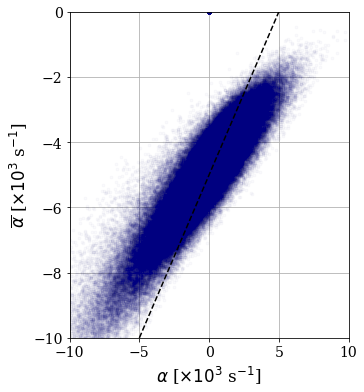

In [31]:
# Compare alpha and alpha_mu
plt.figure(figsize=(5,6))
plt.plot(ds.alpha*1000,ds.alpha_mu*1000,'.', color='navy',alpha=0.02)
plt.grid(b=True)
plt.xlabel(r'$\alpha$ [$\times 10^3$ s$^{-1}$]')
plt.ylabel(r'$\overline{\alpha}$ [$\times 10^3$ s$^{-1}$]')
plt.plot([-5,5],[-10,0],'k--')
plt.xlim(-10,10)
plt.ylim(-10,0)
plt.show()

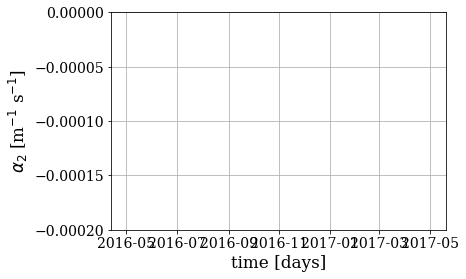

In [32]:
alpha2_mu_min = ds['alpha2_mu'].min(axis=0)
alpha2_mu_max = ds['alpha2_mu'].max(axis=0)
alpha2_mu_50 = np.median(ds['alpha2_mu'], axis=0)

alpha2_min = ds['alpha2'].min(axis=0)
alpha2_max = ds['alpha2'].max(axis=0)
alpha2_50 = np.median(ds['alpha2'], axis=0)

plt.figure()

plt.fill_between(time, alpha2_mu_min, alpha2_mu_max, color='0.5',alpha=0.2)
plt.plot(time,alpha2_mu_50,'--',c='0.5', lw=1.5)

plt.fill_between(time, alpha2_min, alpha2_max, color='b',alpha=0.2)
plt.plot(time,alpha2_50,'b--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel(r'$\alpha_2$ [m$^{-1}$ s$^{-1}$]')
plt.ylim(-0.0002,0.00)
#ax2.set_xticklabels([])
plt.xlabel('time [days]')
plt.grid(b=True)

# Sensitivity analysis

 - histogram of amax < -40
 - scatter of amax vs alpha/a0
 - Monte Carlo filtering (see Saltelli, 2004, Ch. 5)

(0, 0.06)

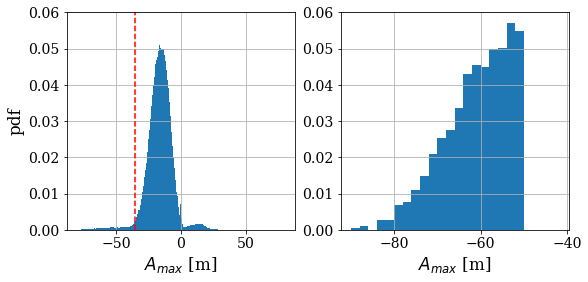

In [77]:
Amax = ds.amax.values
alpha = ds.alpha_mu.values
a0 = ds.a0.values

myLs = Ls_mu.values/L

Amax[Amax==-999] = np.nan
idx = ds.amax < -50

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.hist(Amax.ravel(), bins=np.linspace(-80,80,200),normed=True)
plt.plot([-35,-35],[0,0.06],'r--')
plt.xlabel('$A_{max}$ [m]')
plt.ylabel('pdf')
plt.grid(b=True)
plt.ylim(0,0.06)

plt.subplot(122)
plt.hist(Amax[idx], bins=np.arange(-90,-40,2),normed=True)
plt.xlabel('$A_{max}$ [m]')
#plt.ylabel('pdf')
plt.grid(b=True)
plt.ylim(0,0.06)


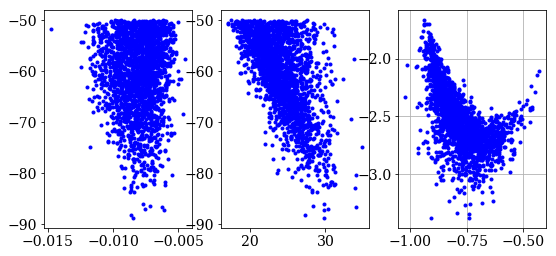

In [78]:
plt.figure(figsize=(9,4))
plt.subplot(131)
plt.plot(alpha[idx],Amax[idx],'b.')

plt.subplot(132)
plt.plot(a0[idx],Amax[idx],'b.')

plt.subplot(133)
plt.plot(myLs[idx],Amax[idx]/a0[idx],'b.')
#plt.xlim(-1,0)
plt.grid(b=True)